# 4.7 Design Deep Reinforcement Learning Agent

In this notebook we will consider an alternative question. Instead of asking how we can maximize profit on a single asset, we will ask whether a machine can pick the best assets given many selections. 

We will consider only price history data. We will provide 90 differenced timesteps on the minute interval period. We will choose the 500 stocks of the S&P 500. 

If our network can outperform the S&P 500 over the given time, we will consider it successful. 

In order to do this, we will need to perform the following steps:

- download datasets for all the stocks in the S&P 500. 
- format the data to represent the simulataneous movement of 500 stocks
- Build an environment to represent this movement
- Train a DQN to learn on it

#### Download datasets for all the stocks in the S&P 500.

In [1]:
from IPython import display
!pip install gcsfs
!pip install tf-agents[reverb]
display.clear_output()

In [2]:
from google.colab import drive
from google.cloud import storage
import pandas as pd
import time
import pandas as pd 
import matplotlib.pyplot as plt
from __future__ import absolute_import, division, print_function

import abc
import tensorflow as tf
import numpy as np
import base64
import IPython
import matplotlib.pyplot as plt
import numpy as np
import os
import tempfile

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent
from tf_agents.agents.sac import tanh_normal_projection_network
from tf_agents.experimental.train import actor
from tf_agents.experimental.train import learner
from tf_agents.experimental.train import triggers
from tf_agents.experimental.train.utils import spec_utils
from tf_agents.experimental.train.utils import strategy_utils
from tf_agents.experimental.train.utils import train_utils
from tf_agents.metrics import py_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import greedy_policy
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_py_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
import reverb

tf.compat.v1.enable_v2_behavior()

In [3]:
# drive.mount('/content/drive')

# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/content/drive/My Drive/fin-aml/fin-aml-gcskeys-337dfd8d8867.json"

# storage_client = storage.Client()
# display.clear_output()

In [4]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

tempdir = tempfile.gettempdir()

In [5]:
# df = pd.read_csv('gs://fin-datasets-aml/data/sp500/spdfm.csv')
# df.set_index('datetime', inplace=True)
# df.head()

In [6]:
# create toy data to test whether the model works
# 505 feature space X
# each X_i = A_i * x + B_i where x exists in {-100, 100}
# a simple line from -100 to 100 to test to the model
import numpy as np
A = np.random.normal(0, .1, size=505).reshape(1,505)
B = np.random.normal(0, .1, size=505).reshape(1,505)
x = np.linspace(-1, 1, 2000).reshape(2000,1)

X = np.matmul(x, A) + B
X.shape

(2000, 505)

In [7]:
# X = df[::-1].to_numpy()

In [8]:
# from sklearn.preprocessing import MinMaxScaler

# mx = MinMaxScaler([-.5,.5])
# X = mx.fit_transform(X)

In [9]:
X.shape

(2000, 505)

In [10]:
import pandas as pd 

pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504
0,-0.164540,-0.043503,-0.084499,0.152406,0.285525,-0.056006,-0.150748,-0.010962,0.013536,0.154553,-0.036267,0.086576,-0.000450,0.147094,0.243426,-0.020298,-0.083235,-0.115102,0.111463,-0.049863,-0.040667,0.077360,0.051466,-0.090031,-0.247560,-0.076548,-0.276460,0.130887,-0.033427,0.319263,0.197019,0.027940,0.070874,-0.217744,-0.049487,0.013633,-0.051024,0.342613,-0.061123,0.007975,0.094679,-0.060865,0.160515,0.370832,0.206664,0.177707,0.010305,0.154637,-0.127650,0.091875,...,-0.103888,0.030449,-0.072375,0.084060,-0.200314,-0.173415,-0.078824,0.032272,-0.327215,0.246959,0.092916,0.136684,0.052101,-0.117799,-0.097961,0.025057,-0.079914,0.003686,0.017816,0.162660,0.151691,-0.169811,-0.286977,0.046300,0.162457,-0.068755,-0.324309,0.198030,-0.074244,0.033139,0.059784,-0.128351,0.217884,0.064765,-0.019849,-0.094946,0.025600,0.126472,-0.141238,-0.083810,0.059785,-0.105976,0.078958,-0.133958,0.125615,0.002990,-0.087544,-0.195172,-0.035026,0.087696
1,-0.164385,-0.043434,-0.084495,0.152406,0.285499,-0.055911,-0.150722,-0.010931,0.013554,0.154456,-0.036234,0.086589,-0.000526,0.146970,0.243333,-0.020292,-0.083187,-0.115039,0.111363,-0.049786,-0.040622,0.077256,0.051399,-0.090095,-0.247410,-0.076487,-0.276273,0.130836,-0.033362,0.319014,0.196961,0.027937,0.070903,-0.217655,-0.049470,0.013631,-0.051026,0.342463,-0.061035,0.008113,0.094657,-0.060770,0.160620,0.370619,0.206669,0.177698,0.010468,0.154517,-0.127518,0.091881,...,-0.103818,0.030347,-0.072356,0.084055,-0.200269,-0.173422,-0.078786,0.032160,-0.327094,0.246769,0.092836,0.136521,0.052175,-0.117762,-0.097835,0.024982,-0.079784,0.003654,0.017685,0.162680,0.151633,-0.169867,-0.286736,0.046273,0.162390,-0.068749,-0.324112,0.198118,-0.074206,0.033185,0.059790,-0.128185,0.217637,0.064824,-0.019906,-0.094876,0.025602,0.126366,-0.141211,-0.083907,0.059759,-0.105940,0.078900,-0.133892,0.125618,0.002928,-0.087578,-0.195038,-0.035052,0.087563
2,-0.164230,-0.043366,-0.084491,0.152406,0.285473,-0.055815,-0.150695,-0.010900,0.013571,0.154358,-0.036202,0.086603,-0.000603,0.146846,0.243240,-0.020287,-0.083140,-0.114977,0.111263,-0.049709,-0.040576,0.077152,0.051331,-0.090159,-0.247260,-0.076426,-0.276085,0.130785,-0.033297,0.318764,0.196902,0.027935,0.070932,-0.217565,-0.049452,0.013629,-0.051028,0.342313,-0.060947,0.008252,0.094636,-0.060675,0.160725,0.370406,0.206674,0.177689,0.010630,0.154396,-0.127385,0.091888,...,-0.103748,0.030245,-0.072337,0.084051,-0.200223,-0.173429,-0.078748,0.032048,-0.326972,0.246579,0.092756,0.136358,0.052249,-0.117725,-0.097708,0.024906,-0.079653,0.003623,0.017555,0.162700,0.151575,-0.169924,-0.286495,0.046246,0.162322,-0.068743,-0.323914,0.198207,-0.074169,0.033232,0.059796,-0.128019,0.217390,0.064883,-0.019963,-0.094807,0.025603,0.126259,-0.141184,-0.084005,0.059732,-0.105905,0.078842,-0.133826,0.125621,0.002866,-0.087613,-0.194904,-0.035079,0.087431
3,-0.164075,-0.043297,-0.084487,0.152406,0.285448,-0.055720,-0.150668,-0.010869,0.013589,0.154261,-0.036170,0.086616,-0.000679,0.146722,0.243147,-0.020282,-0.083093,-0.114915,0.111163,-0.049632,-0.040531,0.077047,0.051263,-0.090222,-0.247110,-0.076364,-0.275897,0.130735,-0.033233,0.318515,0.196843,0.027932,0.070961,-0.217476,-0.049434,0.013627,-0.051030,0.342163,-0.060859,0.008390,0.094615,-0.060580,0.160830,0.370194,0.206678,0.177680,0.010792,0.154276,-0.127253,0.091894,...,-0.103678,0.030143,-0.072318,0.084047,-0.200178,-0.173436,-0.078711,0.031936,-0.326851,0.246389,0.092676,0.136194,0.052323,-0.117689,-0.097581,0.024831,-0.079523,0.003592,0.017424,0.162720,0.151516,-0.169981,-0.286254,0.046220,0.162255,-0.068738,-0.323717,0.198295,-0.074132,0.033278,0.059802,-0.127853,0.217143,0

In [11]:
print(pd.DataFrame(X).describe().loc['min'].min())
print(pd.DataFrame(X).describe().loc['max'].max())

-0.5396492997164709
0.47779568492737506


In [12]:
X = np.array(X, dtype=np.float32)
X.dtype

dtype('float32')

#### Build an environment to represent this movement

In [13]:
class StockMarketEnv(py_environment.PyEnvironment):
    '''
    Observation: The observation should be a (90,505) matrix
    Action: A (505) vector with probabilties from 0 1, max 10 are encoded as 1, all others are 0
    Reward: dot product of the (505,1) top 10 choices with the next (1,505) returns
    '''
    def __init__(self, X):
        self._action_spec = array_spec.BoundedArraySpec(
                                    shape=(1020,), dtype=np.float32, minimum=0, maximum=1, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
                                    shape=(90,505), dtype=np.float32, minimum=-1, maximum=1 ,name='observation')
        self._X = X
        self._state = np.array(self._X[:90], dtype=np.float32)
        self._i = 0
        self._episode_ended = False

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state = np.array(self._X[:90], dtype=np.float32) ## input array
        self._i = 0
        self._episode_ended = False
        return ts.restart(self._state)

    def _step(self, action):
        '''
        Given a state array:
            - Choose the top ten stocks
            - Compute the reward by taking the dot product
            - Update the new state by taking the next timestep
            - Return the ts.transition(new_state, reward, discount=1)
        '''
        if self._episode_ended:
            return self.reset()
        
        action_state = action.copy()
        # action_state[action_state.argsort()[-10:]] = 1
        
        # mask = np.ones(action_state.shape, bool)
        # mask[action_state.argsort()[-10:]] = False
        # action_state[mask] = 0
        
        reward_state = np.array(self._X[91+self._i], dtype=np.float64)
        
        ## modify for hold and sell
        # reward = np.dot(reward_state, action_state)[0]
        reward_pos = np.dot(reward_state, action_state[:505])
        reward_neg = np.dot(-reward_state, action_state[515:])
        reward = reward_pos + reward_neg
        # 10 possible action states for holding cash, idx [505:515] -> zero reward
        
        self._i += 1
        
        if self._i + 91 >= self._X.shape[0]:
            self._episode_ended = True
        
        self._state = np.array(self._X[self._i:90+self._i], dtype=np.float64)
        
        if self._episode_ended:
            return ts.termination(np.array(self._state, dtype=np.float32), reward=np.array(reward, dtype=np.float32))
        else:
            return ts.transition(np.array(self._state, dtype=np.float32), reward=np.array(reward, dtype=np.float32), discount=1.0)

In [14]:
environment = StockMarketEnv(X)
utils.validate_py_environment(environment, episodes=5)

##### Train a DQN to learn on it

In [15]:
# Important interval values for training speed
# Set lower to increase speed of training 

num_iterations = 10000 # @param {type:"integer"}
log_interval = 500 # @param {type:"integer"}=
num_eval_episodes = 1 # @param {type:"integer"}
eval_interval = 1000 # @param {type:"integer"}

In [16]:
initial_collect_steps = 10000 # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_capacity = 10000 # @param {type:"integer"}

batch_size = 256 # @param {type:"integer"}

critic_learning_rate = 3e-4 # @param {type:"number"}
actor_learning_rate = 3e-4 # @param {type:"number"}
alpha_learning_rate = 3e-4 # @param {type:"number"}
target_update_tau = 0.005 # @param {type:"number"}
target_update_period = 1 # @param {type:"number"}
gamma = 0.99 # @param {type:"number"}
reward_scale_factor = 1.0 # @param {type:"number"}

actor_fc_layer_params = (505, 1020)
critic_joint_fc_layer_params = (505, 1020)



policy_save_interval = 5000 # @param {type:"integer"}

In [17]:
X.shape[0], X.shape[0]//2

(2000, 1000)

In [18]:
# Code to produce tf environments
# train_py_env = StockMarketEnv(X[:X.shape[0]//2])
# eval_py_env = StockMarketEnv(X[X.shape[0]//2:])
# train_env = tf_py_environment.TFPyEnvironment(train_py_env)
# eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Code to produce py environments 
train_env = StockMarketEnv(X[:X.shape[0]//2])
eval_env = StockMarketEnv(X[X.shape[0]//2:])

In [19]:
print('Observation Spec:')
print(train_env.time_step_spec().observation)
print('Action Spec:')
print(train_env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(90, 505), dtype=dtype('float32'), name='observation', minimum=-10000.0, maximum=10000.0)
Action Spec:
BoundedArraySpec(shape=(1020,), dtype=dtype('float32'), name='action', minimum=0.0, maximum=1.0)


In [20]:
use_gpu = False 

strategy = strategy_utils.get_strategy(tpu=False, use_gpu=use_gpu)

In [21]:
observation_spec, action_spec, time_step_spec = (spec_utils.get_tensor_specs(train_env))

with strategy.scope():
    critic_net = critic_network.CriticNetwork((observation_spec, action_spec),
                                            observation_fc_layer_params=None,
                                            action_fc_layer_params=None,
                                            joint_fc_layer_params=critic_joint_fc_layer_params,
                                            kernel_initializer='glorot_uniform',
                                            last_kernel_initializer='glorot_uniform')

In [22]:
action_spec

BoundedTensorSpec(shape=(1020,), dtype=tf.float32, name='action', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32))

In [23]:
observation_spec

BoundedTensorSpec(shape=(90, 505), dtype=tf.float32, name='observation', minimum=array(-10000., dtype=float32), maximum=array(10000., dtype=float32))

In [24]:
actor_fc_layer_params

(505, 1020)

In [25]:
with strategy.scope():
    actor_net = actor_distribution_network.ActorDistributionNetwork(observation_spec,
                                                                    action_spec,
                                                                    fc_layer_params=actor_fc_layer_params,
                                                                    continuous_projection_net=(
                                              tanh_normal_projection_network.TanhNormalProjectionNetwork))

In [26]:
time_step_spec

TimeStep(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)), observation=BoundedTensorSpec(shape=(90, 505), dtype=tf.float32, name='observation', minimum=array(-10000., dtype=float32), maximum=array(10000., dtype=float32)))

In [27]:
with strategy.scope():
    train_step = train_utils.create_train_step()

    tf_agent = sac_agent.SacAgent(
                                time_step_spec,
                                action_spec,
                                actor_network=actor_net,
                                critic_network=critic_net,
                                actor_optimizer=tf.compat.v1.train.AdamOptimizer(
                                                                learning_rate=actor_learning_rate),
                                critic_optimizer=tf.compat.v1.train.AdamOptimizer(
                                                                learning_rate=critic_learning_rate),
                                alpha_optimizer=tf.compat.v1.train.AdamOptimizer(
                                                                learning_rate=alpha_learning_rate),
                                target_update_tau=target_update_tau,
                                target_update_period=target_update_period,
                                td_errors_loss_fn=tf.math.squared_difference,
                                gamma=gamma,
                                reward_scale_factor=reward_scale_factor,
                                train_step_counter=train_step)

    tf_agent.initialize()

In [28]:
table_name = 'uniform_table'
table = reverb.Table(
    table_name,
    max_size=replay_buffer_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1))

reverb_server = reverb.Server([table])

In [29]:
reverb_replay = reverb_replay_buffer.ReverbReplayBuffer(
    tf_agent.collect_data_spec,
    sequence_length=2,
    table_name=table_name,
    local_server=reverb_server)

In [30]:
dataset = reverb_replay.as_dataset(
      sample_batch_size=batch_size, num_steps=2).prefetch(50)
experience_dataset_fn = lambda: dataset

In [31]:
tf_eval_policy = tf_agent.policy
eval_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_eval_policy, use_tf_function=True)

In [32]:
tf_collect_policy = tf_agent.collect_policy
collect_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_collect_policy, use_tf_function=True)

In [33]:
rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  reverb_replay.py_client,
  table_name,
  sequence_length=2,
  stride_length=1)

In [34]:
random_policy = random_py_policy.RandomPyPolicy(
  train_env.time_step_spec(), train_env.action_spec())

In [35]:
initial_collect_actor = actor.Actor(
              train_env,
              random_policy,
              train_step,
              steps_per_run=initial_collect_steps,
              observers=[rb_observer])
initial_collect_actor.run()

In [36]:
env_step_metric = py_metrics.EnvironmentSteps()
collect_actor = actor.Actor(
                  train_env,
                  collect_policy,
                  train_step,
                  steps_per_run=1,
                  metrics=actor.collect_metrics(10),
                  summary_dir=os.path.join(tempdir, learner.TRAIN_DIR),
                  observers=[rb_observer, env_step_metric])

In [37]:
eval_actor = actor.Actor(
  eval_env,
  eval_policy,
  train_step,
  episodes_per_run=num_eval_episodes,
  metrics=actor.eval_metrics(num_eval_episodes),
  summary_dir=os.path.join(tempdir, 'eval'),
)

In [38]:
saved_model_dir = os.path.join(tempdir, learner.POLICY_SAVED_MODEL_DIR)

# Triggers to save the agent's policy checkpoints.
learning_triggers = [
    triggers.PolicySavedModelTrigger(
        saved_model_dir,
        tf_agent,
        train_step,
        interval=policy_save_interval),
    triggers.StepPerSecondLogTrigger(train_step, interval=1000),
]

agent_learner = learner.Learner(
  tempdir,
  train_step,
  tf_agent,
  experience_dataset_fn,
  triggers=learning_triggers)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/policies/collect_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/collect_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/greedy_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/greedy_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/policy/assets


In [39]:
%%time
def get_eval_metrics():
    eval_actor.run()
    results = {}
    for metric in eval_actor.metrics:
        results[metric.name] = metric.result()
    return results

metrics = get_eval_metrics()

CPU times: user 1.74 s, sys: 168 ms, total: 1.91 s
Wall time: 1.77 s


In [40]:
%%time
def log_eval_metrics(step, metrics):
    eval_results = (', ').join(
              '{} = {:.6f}'.format(name, result) for name, result in metrics.items())
    print('step = {0}: {1}'.format(step, eval_results))

log_eval_metrics(0, metrics)

step = 0: AverageReturn = -49.755524, AverageEpisodeLength = 909.000000
CPU times: user 73 µs, sys: 0 ns, total: 73 µs
Wall time: 101 µs


In [41]:
training_params = [num_iterations,
                    log_interval,
                    num_eval_episodes,
                    eval_interval]
          
print(training_params)

[10000, 500, 1, 1000]


In [42]:
#@test {"skip": true}
try:
    %%time
except:
    pass

start = time.time()
# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = metrics["AverageReturn"]
returns = [avg_return]

for _ in range(num_iterations):
    # Training.
    collect_actor.run()
    loss_info = agent_learner.run(iterations=1)

    # Evaluating.
    step = agent_learner.train_step_numpy

    if eval_interval and step % eval_interval == 0:
        metrics = get_eval_metrics()
        log_eval_metrics(step, metrics)
        returns.append(metrics["AverageReturn"])

    if log_interval and step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, loss_info.loss.numpy()))
        minsec = divmod((time.time() - start), 60)
        hourmin = divmod(minsec[0], 60)
        print(f"Time elasped: {int(hourmin[0])}:{int(hourmin[1])}:{minsec[1]}")

rb_observer.close()
reverb_server.stop()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs
step = 500: loss = -22.973289489746094
Time elasped: 0:2:10.245006561279297
step = 1000: AverageReturn = 247.676712, AverageEpisodeLength = 909.000000
step = 1000: loss = -77.79386901855469
Time elasped: 0:4:24.699620008468628
step = 1500: loss = -150.63677978515625
Time elasped: 0:6:25.784976720809937
step = 2000: AverageReturn = 1263.975464, AverageEpisodeLength = 909.000000
step = 2000: loss = -216.87747192382812
Time elasped: 0:8:42.66874384880066
step = 2500: loss = -282.59234619140625
Time elasped: 0:10:42.31461048126221
step = 3000: AverageReturn = 2593.271240, AverageEpisodeLength = 909.000000
step = 3000: loss = -355.6470947265625
Time elasped: 0:12:59.927887201309204
step = 3500: loss = -424.946044921875
Time elasped: 0:15:0.5767567157745361
step = 4000: AverageReturn = 3371.513916, AverageEpisodeLength = 909.000000
step = 4000: loss = -493.1053161621094
Time elasped: 0:17:17.404439687728882
step = 4500: loss = -

KeyboardInterrupt: ignored

In [44]:
steps

range(0, 10001, 1000)

In [46]:
returns

[-49.755524, 247.67671, 1263.9755, 2593.2712, 3371.514, 4105.4326]

(-257.51493072509766, 4313.192024230957)

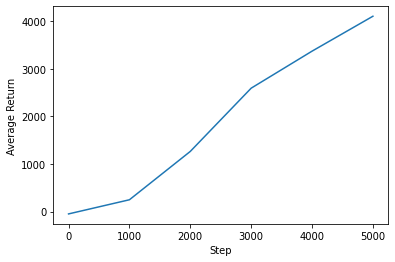

In [47]:
#@test {"skip": true}

steps = range(0, 5500 + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim()

In [48]:
for metric in collect_actor.metrics:
  print(f"{metric.name} = {metric.result()}")

NumberOfEpisodes = 5
EnvironmentSteps = 5049
AverageReturn = 1078.9906005859375
AverageEpisodeLength = 909.0


In [49]:
collect_actor.metrics[2].result()

1078.9906